In [1]:
# Load all_teams_performance_data.csv into a pandas dataframe
import pandas as pd
df = pd.read_csv('all_teams_performance_data.csv')
# Add new column called year which is the first 4 characters of the event_key column
df['year'] = df['event_key'].str[:4].astype(int)

In [2]:
# Copy the dataframe to a new dataframe'
# The new dataframe contains only in-season data where opr is not none and the week is not none
in_season_df = df[(df['opr'].notnull()) & (df['week'].notnull())]

In [3]:
def get_df(year=None, weeks=None, state_prov=None):
    df_filtered = in_season_df.copy()
    
    if year is not None:
        df_filtered = df_filtered[df_filtered['year'] == year]
    
    if weeks is not None:
        df_filtered = df_filtered[df_filtered['week'].isin(weeks)]
    
    if state_prov is not None:
        df_filtered = df_filtered[df_filtered['state_prov'] == state_prov]
    
    return df_filtered

In [4]:
# Add column called normalized_opr which is the opr divided by the max opr for that year (get_opr_100_mean())
mean_opr_per_year = in_season_df.groupby('year')['opr'].transform(lambda x: x.nlargest(1).mean())
in_season_df.loc[:, 'normalized_opr'] = in_season_df['opr'] / mean_opr_per_year

C:\Users\20213116\AppData\Local\Temp\ipykernel_20596\2874919078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_season_df.loc[:, 'normalized_opr'] = in_season_df['opr'] / mean_opr_per_year


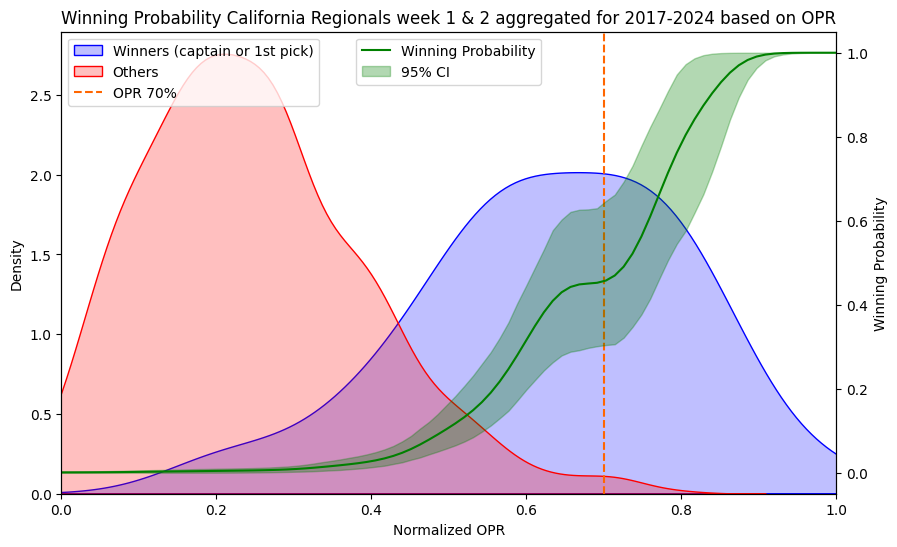

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.utils import resample

def plot_opr_distribution_with_bootstrap(df, n_bootstrap=1000):
    if df.empty:
        print('Dataframe is empty')
        return

    years = df['year'].unique()
    opr_70 = 0.7

    # Assuming in_season_2017_df is your DataFrame
    won_pick_teams = df[(df['status'] == 'won') & (df['pick'] <= 1)]
    other_teams = df[~((df['status'] == 'won') & (df['pick'] <= 1))]

    # Define the OPR target
    opr_target = opr_70

    # Define a range of OPR values
    opr_values = np.linspace(df['normalized_opr'].min(), df['normalized_opr'].max(), 100)

    # Initialize arrays to store bootstrap results
    bootstrap_probabilities = np.zeros((n_bootstrap, len(opr_values)))

    # Perform bootstrapping
    for i in range(n_bootstrap):
        # Resample the data with replacement
        df_resampled = resample(df)

        # Split the resampled data into winning and other teams
        won_pick_teams_resampled = df_resampled[(df_resampled['status'] == 'won') & (df_resampled['pick'] <= 1)]
        other_teams_resampled = df_resampled[~((df_resampled['status'] == 'won') & (df_resampled['pick'] <= 1))]

        # Calculate the KDE using scipy.stats.gaussian_kde
        kde_won = gaussian_kde(won_pick_teams_resampled['normalized_opr'])
        kde_other = gaussian_kde(other_teams_resampled['normalized_opr'])

        # Evaluate the KDE at the range of OPR values
        density_won = kde_won(opr_values)
        density_other = kde_other(opr_values)

        # Calculate the proportion of teams in each group
        proportion_won = len(won_pick_teams_resampled) / len(df_resampled)
        proportion_other = len(other_teams_resampled) / len(df_resampled)

        # Adjust the densities by the proportions
        adjusted_density_won = density_won * proportion_won
        adjusted_density_other = density_other * proportion_other

        # Calculate the winning probability for each OPR value
        total_density = adjusted_density_won + adjusted_density_other
        probability_winning = adjusted_density_won / total_density

        # Store the results
        bootstrap_probabilities[i, :] = probability_winning

    # Calculate the mean and confidence intervals
    mean_probability_winning = np.mean(bootstrap_probabilities, axis=0)
    lower_ci = np.percentile(bootstrap_probabilities, 2.5, axis=0)
    upper_ci = np.percentile(bootstrap_probabilities, 97.5, axis=0)

    # Plot the KDE and the winning probability
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the KDE
    sns.kdeplot(won_pick_teams['normalized_opr'], color='b', label='Winners (captain or 1st pick)', fill=True, ax=ax1)
    sns.kdeplot(other_teams['normalized_opr'], color='r', label='Others', fill=True, ax=ax1)

    # Add vertical line for OPR target
    ax1.axvline(round(opr_target, 2), color='#ff6600', linestyle='--', label='OPR 70%')

    # Add labels and title
    ax1.set_xlabel('Normalized OPR')
    ax1.set_ylabel('Density')
    #ax1.set_title('Distribution of Normalized OPR in {}'.format(years))
    ax1.set_title('Winning Probability California Regionals week 1 & 2 aggregated for 2017-2024 based on OPR')

    # Add a legend
    ax1.legend(loc='upper left')

    # Limit the x-axis to 1.0
    ax1.set_xlim(0, 1.0)

    # Create a second y-axis for the winning probability
    ax2 = ax1.twinx()
    ax2.plot(opr_values, mean_probability_winning, color='g', label='Winning Probability')
    ax2.fill_between(opr_values, lower_ci, upper_ci, color='g', alpha=0.3, label='95% CI')
    ax2.set_ylabel('Winning Probability')

    # Add a legend for the second y-axis
    ax2.legend(loc='upper center')

    # Show the plot
    plt.show()

# Example usage:
plot_opr_distribution_with_bootstrap(get_df(weeks=[0,1], state_prov='CA'), n_bootstrap=1000)